## Aiyagari Steady State
The Stationary Equalibrium in a Production Economy in Alisdair McKay's series on Heterogeneous Agent Modeling.

In [1]:
# load some packages
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy import sparse
import numpy as np
import warnings

# config
A_MIN = 0
A_MAX = 500
N_A = 501
LABOR_EFFICIENCY = np.array([1, 2.5])  # low and high endowments
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = np.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix
ALPHA = 1/3
BETA = 0.98
GAMMA = 2.
DELTA = 0.01

#### The Model
The model has a unit continuum of consumers with CRRA preferences
$$
\mathbb{E} \sum_{t=0}^\infty \beta^t \frac{c_{i, t}^{1-\gamma}}{1-\gamma}
$$
and labor efficiency that fluctuates between $\ell_l$ and $\ell_h$ where $\ell_l < \ell_h$ with transition probabilities $\Pi(\ell' \mid \ell)$. The consumer budget is given by
$$
k_{i, t} + c_{i, t} = R_t k_{i, t-1} + W_t \ell_t.
$$
The distribution of households is defined as $\Gamma(k_{t-1}, \ell_t)$.

Production takes place in a representative firm such that
$$
Y_t = K_{t-1}^\alpha L_t^{1-\alpha}
$$
The FOCs for the firm problem are
\begin{align*}
R_t &= \alpha K_{t-1}^{\alpha - 1} L_t^{\alpha - 1} + 1 - \delta \\
W_t &= (1-\alpha) K_{t-1}^\alpha L_t^{-\alpha}.
\end{align*}

Aggregators are defined as
\begin{align*}
K_{t-1} &= \int_0^1 k_{t-1, i} d i = \int_0^1 k_{t-1, i} d \Gamma(k_{t-1}, \ell_t) \\
L_t &= \int_0^1 \ell_{t, i} d i = \int_0^1 \ell_{t, i} d \Gamma(k_{t-1}, \ell_t)
\end{align*}
Using Walrus's Law, we ignore the aggregation for $Y_t$.

The variables in the model represent
| Variable | Meaning |
| --- | --- |
| $c_{i, t}$ | Individual $i$'s consumption at time $t$ |
| $\ell_{i, t}$ | Individual $i$'s labor efficiency at time $t$ |
| $k_{i, t}$ | Individual $i$'s capital stock at time $t$ |
| $Y_t$ | Output at time $t$ |
| $K_t$ | Aggregate capital stock at time $t$ |
| $L_t$ | Aggregate labor supply at time $t$ |
| $R_t$ | Rental rate of capital at time $t$ |
| $W_t$ | Wage rate at time $t$ |

and the parameters in the model represent
| Parameter | Meaning |
| --- | --- |
| $\beta$ | Intertemporal discount factor |
| $\gamma$ | Risk aversion parameter |
| $\alpha$ | Cobb Douglas parameter |
| $\delta$ | Capital depreciation rate |

#### Aggregate Labor Supply
To find the aggregate labor supply, we need to find the stationary distribution for labor efficiencies. To do this, we let $\vec{\mu}$ be the stationary distribution such that
$$
\vec{\mu} = \begin{pmatrix} \mu_l \\ \mu_h \end{pmatrix}
$$
where $\mu_l$ is the steady state percentage of the population with a low labor efficiency and $\mu_h$ is the steady state percentage of the population with a high labor efficiency. These steady state ratios are defined as the ratios such that
$$
\mathbf{\Pi} \vec{\mu} = \vec{\mu}
$$
where $\mathbf{\Pi}$ is the transition matrix. Since $\mathbf{\Pi}$ is a Markov Matrix, we know its dominant eigenvalue is 1. Therefore, we're looking for the dominant eigenvector of $\mathbf{\Pi}$ as the stationary distribution of labor efficiencies.

In [2]:
# get eigenstuff
vals, vecs = np.linalg.eig(TRAN_MAT)
i = vals.argmax()

# check dominant eigenvalue is correct
assert vals[i] == 1

# get the distribution
labor_dist = vecs[:, i]  # get dominant eigenvector
labor_dist /= labor_dist.sum()  # vector reprsents percentages, normlaize it to sum to 1
L = (labor_dist * LABOR_EFFICIENCY).sum()  # aggragate labor is the dot product between the distribution and efficeicies
L

2.125

#### The Algorithm
To solve for the stationary distribution, we use an iterative algorithm where we
1. Guess $K$
2. Use FOCs to find $W$ and $R$
3. Use the endogenous grid method to find a policy rule $g$ and $c$ for the consumers
4. Find the stationary distribution for $k_{i}$ of the policy rule
5. Find aggregate capital from the stationary distribution
6. Check if aggregate capital matches our initial guess. If it does, we have the solution. If it doesn't, update the initial guess and solve it again.

#### Initial Guess
We'll use the steady state to the RBC version of the problem as our initial guess. We'll also use the equations for $R_t$ and $W_t$ to solve for steady state $R$ and $W$ from this initial guess.

In [3]:
# initial guess for K
K_0 = ((1/BETA - 1 + DELTA) / (ALPHA * L**(1-ALPHA)))**(1/(ALPHA - 1))  # keep as seperate variable to use in loop 
K = K_0

# solutions for R and W from the aggregate labor supply and guessed aggregate capital
R = ALPHA * K**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
W = (1-ALPHA) * K**ALPHA * L**(-ALPHA)

K, R, W

(77.12439490881933, 1.0204081632653061, 2.2072575925885416)

#### EGM Setup
Build the grids that we'll use to implement the endogenous grid method

In [4]:
# gridpoints
grid = np.linspace(A_MIN**(1/4), A_MAX**(1/4), N_A)**4
# we use a grid with more points near the borrowing constraint since there is more curvature there, see Reiter 2009
tiled_grid = np.tile(grid, LABOR_EFFICIENCY[:, None].shape).T  # each row is a different income level. Represent g as a function of only this vector

#### Interpolation and Policy Function Guessing
Using linear interpolation to guess the policy function.

In [5]:
def get_linear_interpolation(x, y):
    '''
    Gets a function that performs a linear interpolation between the
    points in x and y

    If check input is left false, the x values should be sorted and 
    unique
    '''
    # setuo
    n = len(x)
    
    # create and return interpolating function
    def linear_interpolation(X):
        '''
        The function to find the interpolating spline at an X
        '''
        idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
        x_l = x[idx-1]  # values below the x
        y_l = y[idx-1]
        x_h = x[idx]  # values above the x
        y_h = y[idx]
        m = (y_h - y_l) / (x_h - x_l)  # slope
        return y_l + m*(X - x_l)  
    
    return linear_interpolation


def get_g(a, A=grid, spline=get_linear_interpolation):
    '''
    Takes current asset grid and future asset grid and interpolates to
    make a savings function
    '''
    # get interpolating functions
    num_endows = a.shape[1]
    splines = [spline(a[:, i], A) for i in range(num_endows)]

    def g(a):
        '''
        Savings function, takes asset grid and returns how much they save
        '''
        a_prime = np.column_stack([splines[i](a[:, i]) for i in range(num_endows)])
        a_prime[a_prime < A_MIN] = A_MIN
        return a_prime
    
    return g


def get_c(g, R, W):
    '''
    Takes a saving function and returns the consumption function
    '''
    c = lambda a: R*a + W*LABOR_EFFICIENCY - g(a)  # consumption = assets + endowment - next assets
    return c

#### EGM
Use the EGM to find the policy function given our current guess for $K$.

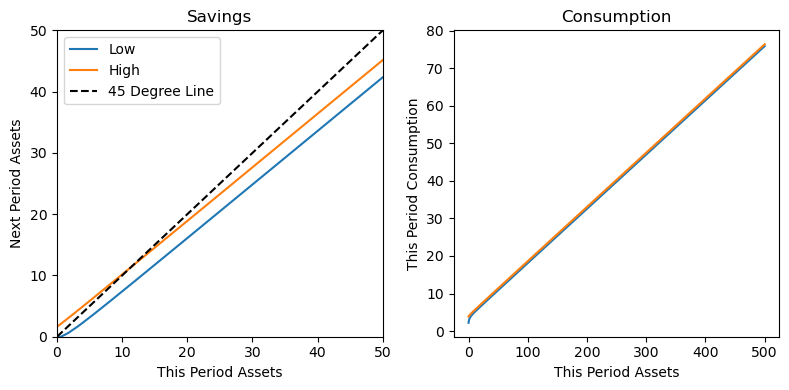

In [6]:
# initial guess
a_current = 10 + 0.1*tiled_grid  # assumed policy function is that you save this amount from each point in the tiled grid
g = get_g(a_current)
c = get_c(g, R, W)

# loop
tol = 1e-10
max_iter = 10000
for _ in range(max_iter):
    # update rule
    c_prime = c(tiled_grid)
    deriv_u_prime = c_prime**(-GAMMA)
    expect_deriv_u_prime = deriv_u_prime @ TRAN_MAT  # expectation
    c_current = (BETA * R * expect_deriv_u_prime)**(-1/GAMMA)
    a_current = 1/R * (c_current + tiled_grid - W*LABOR_EFFICIENCY)

    # make functions
    g, last_g = get_g(a_current), g
    c = get_c(g, R, W)

    # exit conditions
    diff = np.abs(g(tiled_grid) - last_g(tiled_grid)).max()
    if diff < tol:
        break
else:
    warnings.warn('Max iteration count exceeded')

# setup plot
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(4)
ax[0].set_title('Savings')
ax[0].set_xlabel('This Period Assets')
ax[0].set_ylabel('Next Period Assets')
ax[1].set_title('Consumption')
ax[1].set_xlabel('This Period Assets')
ax[1].set_ylabel('This Period Consumption')

# plot it
ax[0].plot(grid, g(tiled_grid), label=['Low', 'High'])
ax[0].plot([A_MIN, A_MAX], [A_MIN, A_MAX], 'k--', label='45 Degree Line')
ax[0].set_xlim((0, 50))  # all the interesting stuff happens closer to 0
ax[0].set_ylim((0, 50))
ax[1].plot(grid, c(tiled_grid))

# final things
ax[0].legend()
fig.tight_layout()

#### Stationary Distribution of Capital
Use the policy rules we found to create a stationary distribution for capital.

To do this, we'll create a transition matrix that maps one household's state (capital and labor efficiency) in one period to their state in the next.

We'll represent the current states as a vector $\vec{\nu}$ where
$$
\vec{\nu} = \begin{pmatrix} \vec{\nu}_l \\ \vec{\nu}_h \end{pmatrix}
$$
where $\vec{\nu}_l$ is the wealth distribution for the fraction of the population with low labor efficiency and $\vec{\nu}_h$ is the wealth distribution for the fraction of the population with high labor efficiency.

To find this vector, we'll create a transition matrix $\Pi_{k, \ell}$ that maps one's capital and labor efficiency in one period to their capital and labor efficiency in the next. Since we are representing both states along a discrete grid, most states don't map to an exact level of capital along the grid. In these cases, we map $p_l$ of the group to the capital amount $k_l$ on the grid directly below the actual value $k^*$ and $p_h$ to the capital amount $k_h$ on the grid directly above the actual value such that
$$
p_l k_l + p_h k_h = k^*
$$
meaning the total amount of capital is preserved.

If $k_h$ is larger than our highest gridpoint, we set $p_l$ to 1. This makes it important to choose a max gridpoint so that the percentage of the population with capital above it is negligible.

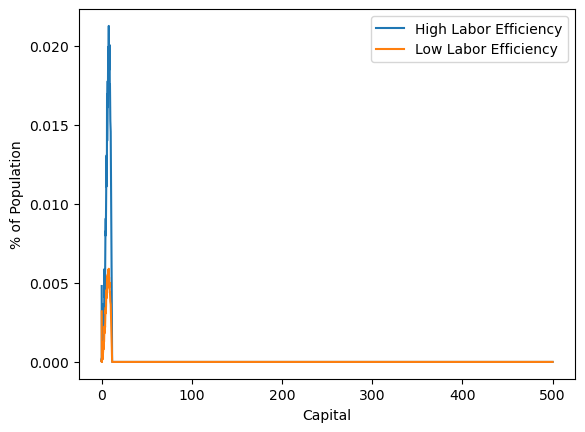

In [7]:
grid_save = g(tiled_grid)  # how much you save at each gridpoint
idxs = np.minimum(np.searchsorted(grid, grid_save, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
p_l = np.maximum((grid[idxs] - grid_save) / (grid[idxs] - grid[idxs-1]), 0)  # how close it is to the lower of the gridpoints we map to 
# 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
p_h = 1 - p_l  # how close it is to the upper half

# check that gridpoints map to what we said
assert (np.isclose(p_h * grid[idxs] + p_l * grid[idxs-1], grid_save) | (grid_save > A_MAX)).all()

# create transition matricies
# low wage: capital now -> capital later
data_l = np.concatenate([p_l[:, 0], p_h[:, 0]])
mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
data_l = data_l[mask_l]
row_l = np.concatenate([idxs[:, 0]-1, idxs[:, 0]])[mask_l]
col_l = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_l]
tran_mat_l = sparse.csr_array((data_l, (row_l, col_l)), shape=(N_A, N_A))

# high wage: capital now -> capital later
data_h = np.concatenate([p_l[:, 1], p_h[:, 1]])
mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
data_h = data_h[mask_h]
row_h = np.concatenate([idxs[:, 1]-1, idxs[:, 1]])[mask_h]
col_h = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_h]
tran_mat_h = sparse.csr_array((data_h, (row_h, col_h)), shape=(N_A, N_A))

# create overall transition matrix
tran_mat = sparse.hstack([
        sparse.vstack(np.kron(tran_mat_l, TRAN_MAT[:, 0])),  # left side of transition matrix, capital with low efficiency -> capital and efficiency next period
        sparse.vstack(np.kron(tran_mat_h, TRAN_MAT[:, 1]))  # right side of transition matrix, capital with high efficiency -> capital and efficiency next period
    ])

# check we have a markov matrix
assert np.allclose(tran_mat.sum(axis=0), 1)

# use eigenvalues to get the steady state distribution of capital
dist = sparse.linalg.eigs(tran_mat, k=1)[1].real  # get dominant eigenvector
dist /= dist.sum()  # normalize to sume to 1
dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

# plot it
plt.plot(grid, dist[:, 1], label='High Labor Efficiency')
plt.plot(grid, dist[:, 0], label='Low Labor Efficiency')
plt.xlabel('Capital')
plt.ylabel('% of Population')
plt.legend()

#### Calculate Total Capital
Using our distribution, we can calculate the aggregate level of capital and check if it aligns with our initial guess (it doesn't).

If we want to, we create a supply and demand line for capital using ($R$, initial guess) as the supply and ($R$, calculated value from the distribution) as our demand.

In [8]:
# capital = sum(% of people with that level of capital * level of capital)
K_d = (grid * dist.T).sum()
K_d, K

(6.330946758260573, 77.12439490881933)

#### Full Implementation
We implement all of this logic into a loop that runs until the guess for capital matches the distribution for capital.

Note: The plotted distribution isn't accurate because of the unevenness of the grid. If the gridpoints were evenly spaced, it would be much higher on the left. 

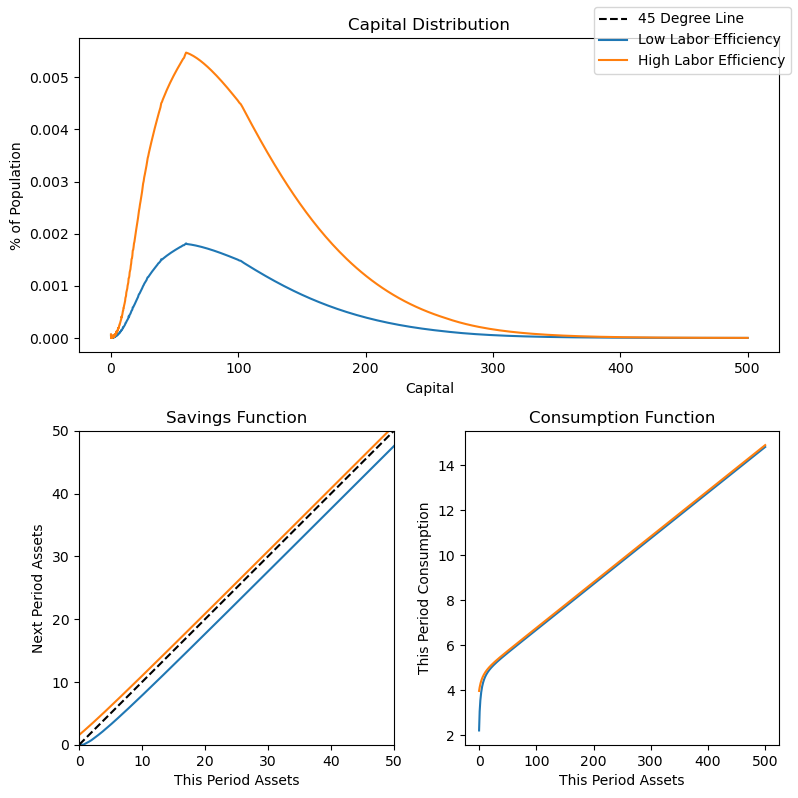

In [11]:
# capital guess loop params
capital_max_iter = 100  # max number of gueses for capital
capital_tol = 1e-10  # actual capital will be within this distance of capital

# policy function loop params
policy_max_iter = 10000  # max number of guesses for the policy function
policy_tol = 1e-10  # loop until two iterations are within this distance max of each other

# params
a_current = 10 + 0.1*tiled_grid  # assumed policy function is that you save this amount from each point in the tiled grid
g = get_g(a_current)
c = get_c(g, R, W)
current_funcs = [g, c]  # we store the functions in a mutable object so the last iterations function can be used for the next iteration

# simulation function
def simulate_K(K, tol=policy_tol, max_iter=policy_max_iter):
    g, c = current_funcs

    # find r and w based on our current guess
    R = ALPHA * K**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
    W = (1-ALPHA) * K**ALPHA * L**(-ALPHA)

    ## find policy function for this capital level
    for _ in range(max_iter):
        # update rule
        c_prime = c(tiled_grid)
        deriv_u_prime = c_prime**(-GAMMA)
        expect_deriv_u_prime = deriv_u_prime @ TRAN_MAT  # expectation
        c_current = (BETA * R * expect_deriv_u_prime)**(-1/GAMMA)
        a_current = 1/R * (c_current + tiled_grid - W*LABOR_EFFICIENCY)

        # make functions
        g, last_g = get_g(a_current), g
        c = get_c(g, R, W)

        # exit conditions
        diff = np.abs(g(tiled_grid) - last_g(tiled_grid)).max()
        if diff < tol:
            break
    else:
        warnings.warn('Policy Loop: Max iteration count exceeded')

    ## get the stationary distribution of capital
    grid_save = g(tiled_grid)  # how much you save at each gridpoint
    idxs = np.minimum(np.searchsorted(grid, grid_save, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = np.maximum((grid[idxs] - grid_save) / (grid[idxs] - grid[idxs-1]), 0)  # how close it is to the lower of the gridpoints we map to 
    # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # low wage: capital now -> capital later
    data_l = np.concatenate([p_l[:, 0], p_h[:, 0]])
    mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_l = data_l[mask_l]
    row_l = np.concatenate([idxs[:, 0]-1, idxs[:, 0]])[mask_l]
    col_l = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_l]
    tran_mat_l = sparse.csr_array((data_l, (row_l, col_l)), shape=(N_A, N_A))

    # high wage: capital now -> capital later
    data_h = np.concatenate([p_l[:, 1], p_h[:, 1]])
    mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_h = data_h[mask_h]
    row_h = np.concatenate([idxs[:, 1]-1, idxs[:, 1]])[mask_h]
    col_h = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_h]
    tran_mat_h = sparse.csr_array((data_h, (row_h, col_h)), shape=(N_A, N_A))

    # create overall transition matrix
    tran_mat = sparse.hstack([
            sparse.vstack(np.kron(tran_mat_l, TRAN_MAT[:, 0])),  # left side of transition matrix, capital with low efficiency -> capital and efficiency next period
            sparse.vstack(np.kron(tran_mat_h, TRAN_MAT[:, 1]))  # right side of transition matrix, capital with high efficiency -> capital and efficiency next period
        ])

    # use eigenvalues to get the steady state distribution of capital
    dist = sparse.linalg.eigs(tran_mat, k=1)[1].real  # get dominant eigenvector
    dist /= dist.sum()  # normalize to sume to 1
    dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    # get aggregate demand
    K_d = (grid * dist.T).sum()

    current_funcs[0], current_funcs[1] = g, c
    return K_d, R, W, c, g, dist

# find equalibrium
K = brentq(lambda K: simulate_K(K)[0] - K, K_0, K_0+25., xtol=capital_tol, maxiter=capital_max_iter)
_, _, _, c, g, dist = simulate_K(K)  # get the economic variables

# setup plot
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 0].set_xlim((0, 50))  # all the interesting stuff happens closer to 0
axs[1, 0].set_ylim((0, 50))
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')

# plot it
axtop.plot(grid, dist[:, 0], label='Low Labor Efficiency')
axtop.plot(grid, dist[:, 1], label='High Labor Efficiency')
axs[1, 0].plot(grid, g(tiled_grid))
axs[1, 0].plot([A_MIN, A_MAX], [A_MIN, A_MAX], 'k--', label='45 Degree Line')
axs[1, 1].plot(grid, c(tiled_grid))

# final things
fig.legend()
fig.tight_layout()